<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-libraries" data-toc-modified-id="Load-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load libraries</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Train-model" data-toc-modified-id="Train-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train model</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></div>

# Load libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import evaluation
import _pickle as cPickle

# Load data

In [2]:
data_dir = "./data/"  + "dataset/"

MFCC_LEN_LIM = 700
N_MFCC = 13
FOLDS = 10

In [3]:
def load_data(folds):
    X = []
    y = []
    for fold in folds:
        with open(data_dir + f"data_mfcc_{fold}.pkl", 'rb') as f:
            data_mfcc = cPickle.load(f)

        for i in range(len(data_mfcc['sentence_I'])):
            if data_mfcc['sentence_I'][i].shape[0] < MFCC_LEN_LIM:
                sentence_I = np.zeros((MFCC_LEN_LIM, N_MFCC), dtype=np.float32)
                sentence_I[-data_mfcc['sentence_I'][i].shape[0]:] = data_mfcc['sentence_I'][i]
            else:
                sentence_I = data_mfcc['sentence_I'][i]
                
            if data_mfcc['sentence_II'][i].shape[0] < MFCC_LEN_LIM:
                sentence_II = np.zeros((MFCC_LEN_LIM, N_MFCC), dtype=np.float32)
                sentence_II[-data_mfcc['sentence_II'][i].shape[0]:] = data_mfcc['sentence_II'][i]
            else:
                sentence_II = data_mfcc['sentence_II'][i]
            X.append([sentence_I, sentence_II])
            y.append(data_mfcc['same_speaker'][i])
    return np.array(X), np.array(y)

In [4]:
X_train, y_train = load_data([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
X_train.shape

(100000, 2, 700, 13)

In [5]:
np.save(data_dir + "data_mfcc_x.npy", X_train)
np.save(data_dir + "data_mfcc_y.npy", y_train)

In [4]:
X_train = np.load(data_dir + "data_mfcc_x.npy")
y_train = np.load(data_dir + "data_mfcc_y.npy")

In [5]:
X_val, y_val = load_data(["val"])
X_val.shape

(10000, 2, 700, 13)

# Train model

In [4]:
from modeling.gru_gru import GRU_GRU

model = GRU_GRU(num_features=N_MFCC)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 13)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 13)]   0                                            
__________________________________________________________________________________________________
gru (GRU)                       (None, None, 64)     15168       input_1[0][0]                    
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, None, 64)     15168       input_2[0][0]                    
_______________________________________________________________________________________

In [8]:
model.fit(X_train, y_train, epochs=100, early_stopping_rounds=7, X_val=X_val, y_val=y_val)

Epoch 1/100
3125/3125 [==============================] - 284s 91ms/step - loss: 0.4809 - acc: 0.7859 - val_loss: 0.5832 - val_acc: 0.7523
Epoch 2/100
3125/3125 [==============================] - 278s 89ms/step - loss: 0.2835 - acc: 0.8904 - val_loss: 0.5928 - val_acc: 0.7723
Epoch 3/100
3125/3125 [==============================] - 277s 88ms/step - loss: 0.2179 - acc: 0.9209 - val_loss: 0.6124 - val_acc: 0.7934
Epoch 4/100
3125/3125 [==============================] - 266s 85ms/step - loss: 0.1836 - acc: 0.9354 - val_loss: 0.7843 - val_acc: 0.7917
Epoch 5/100
3125/3125 [==============================] - 263s 84ms/step - loss: 0.1594 - acc: 0.9453 - val_loss: 0.6263 - val_acc: 0.8177
Epoch 6/100
3125/3125 [==============================] - 254s 81ms/step - loss: 0.1431 - acc: 0.9520 - val_loss: 0.7055 - val_acc: 0.7954
Epoch 7/100
3125/3125 [==============================] - 254s 81ms/step - loss: 0.1318 - acc: 0.9565 - val_loss: 1.0670 - val_acc: 0.7773
Epoch 8/100
3125/3125 [===========

In [6]:
model.save_weights()

# Evaluation

In [5]:
model.load_weights()

In [6]:
X_test, y_test = load_data(["test"])

In [7]:
y_pred = model.predict(X_test)

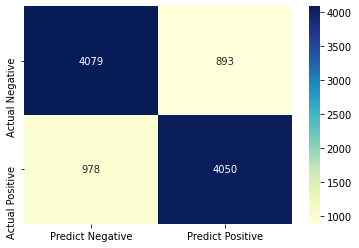

In [8]:
evaluation.plot_confusion_matrix(y_test, y_pred)

In [9]:
evaluation.print_classification_report(y_test, y_pred)

Classification report:
               precision    recall  f1-score   support

       False       0.81      0.82      0.81      4972
        True       0.82      0.81      0.81      5028

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



In [13]:
evaluation.get_f1_score(y_test, y_pred, average='macro')

0.8128984264757666